In [297]:
from __future__ import absolute_import, division

import os
import urllib, cStringIO

import pymongo as pm

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys
from collections import Counter

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [319]:
# directory & file hierarchy
proj_dir = os.path.abspath('../../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
stimuli_dir = os.path.join(proj_dir,'stimuli')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis','python') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis','python'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/judithfan/graphical_conventions/analysis/python/analysis_helpers.pyc'>

### setup

In [431]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['3dObjects']
coll = db['graphical_conventions_recog']

# which iteration name should we use?
iterationName = 'pilot3'

### get basic participation stats

In [441]:
## list of researchers
researchers = ['A4SSYO0HDVD4E', 'A1BOIDKD33QSDK','A1MMCS8S8CTWKU']
num_correct_thresh = 0
num_catch_correct_thresh = 4

## get list of valid sessions with reasonable accuracy
workers = coll.find({ '$and': [{'iterationName':iterationName}]}).distinct('workerId')
workers = [i for i in workers if len(i)>10 and i not in researchers] ## filter workers
print '{} workers performed this task'.format(len(workers))

204 workers performed this task


In [442]:
## get total number of recog events in the collection as a whole
top_workers = []
for i,w in enumerate(workers):
    print 'Analyzing {} | {} of {}'.format(w,str(i).zfill(3),len(workers))
    clear_output(wait=True)
    R = coll.find({ '$and': [{'iterationName':iterationName}, {'workerId': w}]}).sort('time',-1)
    if R.count()==45:
        num_correct = coll.find({ '$and': [{'iterationName':iterationName}, {'workerId': w},{'catch_trial':False},{'correct':1}]}).sort('time',-1).count()
        num_catch_trial_correct = coll.find({ '$and': [{'iterationName':iterationName}, {'workerId': w},{'catch_trial':True},{'correct':1}]}).sort('time',-1).count()    
        num_catch_trials_shown = coll.find({ '$and': [{'iterationName':iterationName}, {'workerId': w},{'catch_trial':True}]}).sort('time',-1).count()
        ## make sure: (1) num correct was higher than thresh, (2) all 5 catch trials showed, 
        ## (3) catch trials were correct above threshold, and (4) it was a full session 
        if (num_correct >= num_correct_thresh) & (num_catch_trials_shown==5) & \
            (num_catch_trial_correct >= num_catch_correct_thresh): 
                top_workers.append(w)
        
print '{} workers got at least {} experimental trials correct and {} catch trials correct and finished the entire HIT.'.format(len(top_workers),num_correct_thresh, num_catch_correct_thresh)        

172 workers got at least 0 experimental trials correct and 4 catch trials correct and finished the entire HIT.


In [443]:
## check how much to bonus a particular worker via compensation HIT
reallyRun = 0
if reallyRun:
    w = ''
    C = coll.find({ '$and': [{'iterationName':iterationName}, {'workerId': w}]}).sort('time',-1)
    for c in C:
        print c['score'], c['numCorrectSoFar']
        clear_output(wait=True)

### construct group dataframe

In [435]:
## get total number of recog events in the collection as a whole
# grab rep & accuracy
rep = []
correct = []
rt = []
condition = []
orig_correct = []
generalization = []
target = []
distractor1 = []
distractor2 = []
distractor3 = []
orig_gameID = []
gameID = []
version = [] ## yoked vs. scrambled40 vs. scrambled 10
recog_id = []
for i,w in enumerate(top_workers):
    print 'Now analyzing {} | {} of {}'.format(w,str(i+1).zfill(3), len(top_workers))
    clear_output(wait=True)
    R = coll.find({ '$and': [{'iterationName':iterationName}, {'workerId': w},{'catch_trial':False}]}).sort('time')
    for r in R:        
        rep.append(r['repetition'])
        correct.append(r['correct'])
        rt.append(r['rt'])
        condition.append(r['condition'])
        if 'outcome' in r.keys():
            orig_correct.append(r['outcome'])
        else:
            orig_correct.append(r['original_correct'])
        generalization.append(r['Generalization'])
        target.append(r['target'])
        distractor1.append(r['distractor1'])
        distractor2.append(r['distractor2'])
        distractor3.append(r['distractor3'])
        orig_gameID.append(r['sketch'].split('_')[0])
        gameID.append(r['gameID'])
        version.append(r['version'])
        recog_id.append(r['recog_id'])
    
### make dataframe
X = pd.DataFrame([rep,correct,rt,condition,orig_correct,\
                 generalization,target,distractor1,distractor2,\
                 distractor3,orig_gameID,gameID,version,recog_id])
X = X.transpose()
X.columns = ['repetition','correct','rt','condition', 'orig_correct',\
             'generalization','target','distractor1','distractor2',\
             'distractor3','orig_gameID','gameID','version','recog_id']

## convert datatypes to numeric
X['correct'] = pd.to_numeric(X['correct'])
X['rt'] = pd.to_numeric(X['rt'])
X['orig_correct'] = pd.to_numeric(X['orig_correct'])
    
print 'Finished analyzing top workers.'
print 'There are {} observation in the dataframe.'.format(X.shape[0])

Finished analyzing top workers.
There are 6840 observation in the dataframe.


#### preprocessing helper 

In [436]:
## function to unroll target, distractor dicts into separate columns
def dict2cols(X,item='target'):
    '''
    X = dataframe containing group data
    item = which item column to unroll: target? distractor1? 
    '''
    df = pd.DataFrame.from_dict(X[item]) ## make temporary dataframe with dictionary as main column
    df2 = df[item].apply(pd.Series) ## separate into different columns
    ## rename to ensure uniqueness
    df3 = df2.rename(columns={'objectname': '{}_objectname'.format(item),\
                              'shapenetid': '{}_shapenetid'.format(item),\
                              'url': '{}_url'.format(item)})
    X2 = X.join(df3) ## add to original group dataframe
    X2.drop(labels=[item],axis=1,inplace=True) ## remove old dictionary column
    return X2

## now actually apply unrolling function
items = ['target','distractor1','distractor2','distractor3']
for item in items: 
    print 'Unrolling {}'.format(item)
    clear_output(wait=True)
    if item in X.columns:
        X = dict2cols(X,item=item)
        
print 'Finished unrolling item dictionaries into separate columns.'

Finished unrolling item dictionaries into separate columns.


In [453]:
## view recognizability by repetition in tabular form
X.groupby(['condition','repetition'])['correct'].mean()

condition  repetition
control    0             0.625731
           1             0.662281
repeated   0             0.659357
           1             0.691520
           2             0.754386
           3             0.713450
           4             0.766082
           5             0.754386
           6             0.770468
           7             0.777778
Name: correct, dtype: float64

In [454]:
## how many games from each version were finished?
X.groupby('version')['repetition'].count()/40

version
scrambled40     67.0
yoked          104.0
Name: repetition, dtype: float64

In [455]:
## how many times did sketches from each orig_gameID get shown to yoked participants?

## how many times did sketches from each orig_gameID get shown to scrambled40 participants?
# X.groupby(['version',' orig_gameID']).count().reset_index()

In [456]:
## subset by yoked experiment 
Y = X[X['version']=='yoked']

## which orig_gameIDs got played in yoked?
orig_gameIDs_yoked = Counter(Y['orig_gameID']).keys()

## how many orig_gameIDs got played in yoked?
num_unique_orig_games = len(Counter(Y['orig_gameID']).keys())
print '{} original gameIDs appeared in the yoked experiment.'.format(num_unique_orig_games)

## how many times did each of the orig_gameIDs that did appear in yoked experiment get played?
orig_gameIDs_reps = Counter([int(i/40) for i in Counter(Y['orig_gameID']).values()])
for entry in orig_gameIDs_reps.keys():
    print '   {} were played {} times in the yoked experiment.'.format(orig_gameIDs_reps[entry],entry)

## which original gameIDs not yet represented in the yoked dataset?
## load in original group_data
path_to_group_data = os.path.join(results_dir,'graphical_conventions.csv')
O = pd.read_csv(path_to_group_data)
orig_gameID_list = list(np.unique(O['gameID']))
orig_gameIDs_not_yet_yoked = [i for i in orig_gameID_list if i not in orig_gameIDs_yoked]
print 'There are {} original gameIDs that have not yet been played in the yoked experiment.'.format(len(orig_gameIDs_not_yet_yoked))

## save out list of gameIDs remaining in the stimuli folder, to allow these to be uploaded as their own dataset
## for targeted recruitment
U = pd.DataFrame(orig_gameIDs_not_yet_yoked)
U.columns = ['gameID']
U.to_csv(os.path.join(stimuli_dir,'orig_gameIDs_remaining_yoked.csv'),index=False)
print 'Saving out this list of gameIDs in the stimuli folder, to allow these to be uploaded as their own dataset for targeted recruitment.'

65 original gameIDs appeared in the yoked experiment.
   35 were played 1 times in the yoked experiment.
   23 were played 2 times in the yoked experiment.
   5 were played 3 times in the yoked experiment.
   2 were played 4 times in the yoked experiment.
There are 2 original gameIDs that have not yet been played in the yoked experiment.
Saving out this list of gameIDs in the stimuli folder, to allow these to be uploaded as their own dataset for targeted recruitment.


In [458]:
## subset by scrambled40
S = X[X['version']=='scrambled40']

## how many recog_ids got played in yoked?
num_unique_orig_recogids = len(Counter(S['recog_id']).keys())
print '{} recog_ids appeared in the scrambled40 experiment.'.format(num_unique_orig_recogids)

## which recog_ids got played in scrambled40?
recog_ids_scrambled = Counter(S['recog_id']).keys()

recog_id_reps = Counter([int(i) for i in Counter(S['recog_id']).values()])
for entry in sorted(recog_id_reps.keys()):
    print '   {} games appeared {} trials from them appear in the scrambled40 experiment.'.format(recog_id_reps[entry],entry)

## which recog_ids remaining?
recog_id_list = list(np.unique(O['recog_id']))
recog_ids_remaining = [i for i in recog_id_list if i not in recog_ids_scrambled]
grouped_recog_ids_remaining = np.unique([np.int64(i/4) for i in orig_recog_ids_not_yet_yoked])
print 'There are still {} grouped_recog_ids to run.'.format(len(grouped_recog_ids_remaining))

U = pd.DataFrame(grouped_recog_ids_remaining)
U.columns = ['grouped_recog_id']
U.to_csv(os.path.join(stimuli_dir,'grouped_recog_ids_remaining_scrambled40.csv'),index=False)
print 'Saving out this list of recogIDs in the stimuli folder, to allow these to be uploaded as their own dataset for targeted recruitment.'

176 recog_ids appeared in the scrambled40 experiment.
   92 games appeared 10 trials from them appear in the scrambled40 experiment.
   76 games appeared 20 trials from them appear in the scrambled40 experiment.
   8 games appeared 30 trials from them appear in the scrambled40 experiment.
There are still 23 grouped_recog_ids to run.
Saving out this list of recogIDs in the stimuli folder, to allow these to be uploaded as their own dataset for targeted recruitment.


### visualize recognizability x repetition

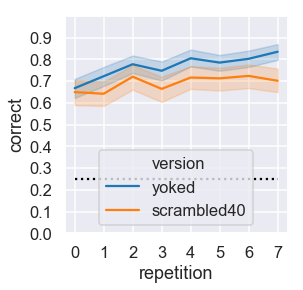

In [409]:
## get dataframe subsetted by condition and broken out by target
X2 = X[X['condition']=='repeated'].reset_index(drop=True)
X2 = X2.sort_values(by=['target_objectname'])
targ_list = np.unique(X2.target_objectname.values)
sns.set_context('talk')

## plot recognizability, collapsing across target
fig = plt.figure(figsize=(4,4))
sns.lineplot(data=X2,x='repetition',y='correct',hue='version')
plt.ylim(0,1)
plt.yticks(np.arange(0, 1, 0.1))
plt.xticks(np.arange(0, 8, 1))
plt.plot([0,7],[0.25,0.25],color='black',linestyle=':')

# ## plot recognizability, split out by target
# fig = plt.figure(figsize=(16,16))
# g = sns.FacetGrid(X2, col="target_objectname", col_wrap=4,height=3, margin_titles=False)
# g.map(sns.lineplot, "repetition", "correct", alpha=.7)
# g.set_titles("{col_name}")
# plt.tight_layout()

### aggregate with original refgame dataset and compare

In [290]:
## load in original group_data
path_to_group_data = os.path.join(results_dir,'graphical_conventions.csv')
O = pd.read_csv(path_to_group_data)

In [291]:
## aggregate original refgame and recog dataframes
## and add some handy additional fields
OR = O[O['condition']=='repeated'].reset_index(drop=True)
OR = OR.rename(columns={'outcome':'correct'})
OR['logRT'] = np.log(OR['drawDuration']*1000)
OR['version'] = pd.Series(['refgame']*len(OR))
# X2['expID'] = pd.Series(['recog']*len(X2))
X2['logRT'] = np.log(X2['rt']) ## add log RT
## concatenated original and recog experiments
R = pd.concat([OR,X2],axis=0,sort=False)

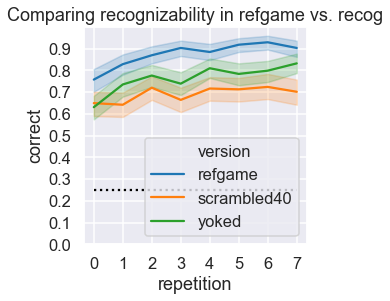

In [292]:
fig = plt.figure(figsize=(4,4))
sns.lineplot(data=R,x='repetition',y='correct',hue='version')
plt.ylim(0,1)
plt.yticks(np.arange(0, 1, 0.1))
plt.xticks(np.arange(0, 8, 1))
plt.plot([0,7],[0.25,0.25],color='black',linestyle=':')
plt.legend(loc = 'lower right')
t = plt.title('Comparing recognizability in refgame vs. recog')

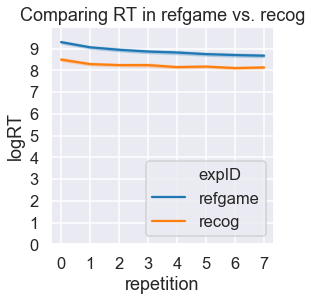

In [209]:
fig = plt.figure(figsize=(4,4))
sns.lineplot(data=R,x='repetition',y='logRT',hue='expID')
plt.ylim(0,10)
plt.yticks(np.arange(0, 10, 1))
plt.xticks(np.arange(0, 8, 1))
# plt.plot([0,7],[0.25,0.25],color='black',linestyle=':')
plt.legend(loc = 'lower right')
t = plt.title('Comparing RT in refgame vs. recog')

### visualize rt x repetition

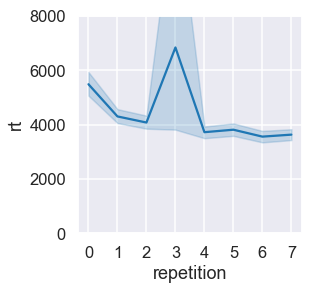

<Figure size 1152x1152 with 0 Axes>

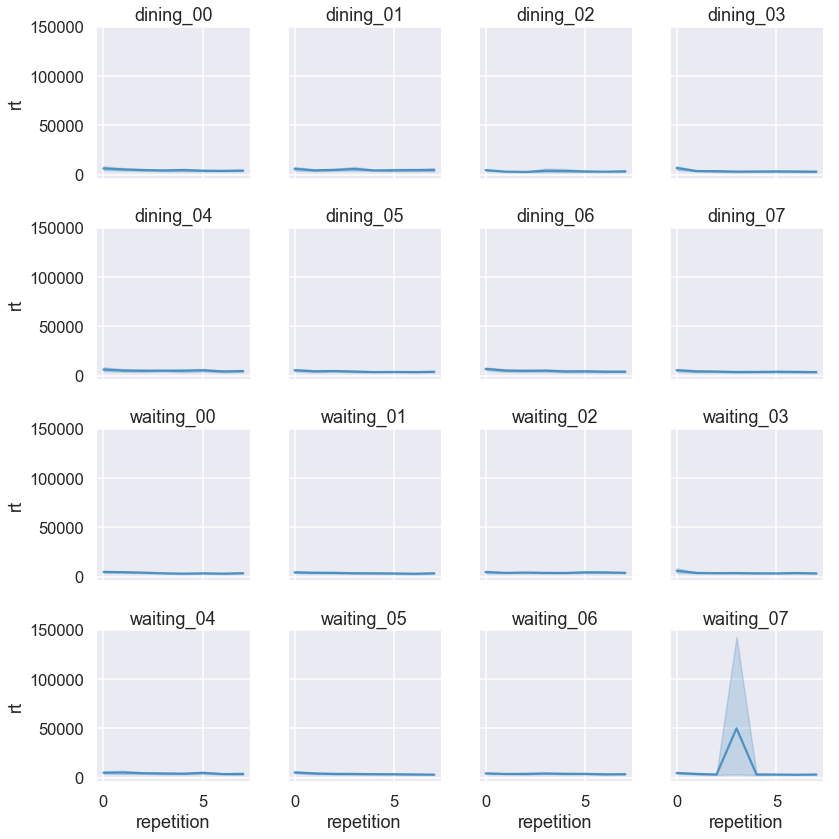

In [210]:
## get dataframe subsetted by condition and broken out by target
X2 = X.query("condition=='repeated'")
X2 = X2.sort_values(by=['target_objectname'])
targ_list = np.unique(X2.target_objectname.values)
sns.set_context('talk')

## plot rt, collapsing across target
fig = plt.figure(figsize=(4,4))
sns.lineplot(data=X2,x='repetition',y='rt')
plt.ylim(0,1)
plt.yticks(np.arange(0, 10000, 2000))
plt.xticks(np.arange(0, 8, 1))

## plot rt, split out by target
fig = plt.figure(figsize=(16,16))
g = sns.FacetGrid(X2, col="target_objectname", col_wrap=4,height=3, margin_titles=False)
g.map(sns.lineplot, "repetition", "rt", alpha=.7)
g.set_titles("{col_name}")
plt.tight_layout()

### compute BIS (z-score within original gameID)

In [147]:
def zscore(x,mu,sd):
    return (x-mu)/(sd+1e-6)

In [131]:
## sort dataframe by original gameID, repetition, and target_objectname
X3 = X2.sort_values(by=['orig_gameID','repetition','target_objectname']).reset_index(drop=True)

In [132]:
## groupby original gameID
grouped = X3.groupby('orig_gameID')

## init new aggregated vars
acc_norm = []
rt_norm = []
bis = []
orig_gameID = []
repetition = []

## loop through games
for name, group in grouped:
    print 'Analyzing {}'.format(name)
    clear_output(wait=True)
    rt_mu = group['logRT'].mean()
    rt_sd = group['logRT'].std()    
    acc_mu = group['correct'].mean()
    acc_sd = group['correct'].std()
    repwise = group.groupby('repetition')
    ## loop through reps within games
    for name,rep in repwise:
        rep_acc_raw = rep['correct'].mean()
        rep_rt_raw = rep['logRT'].mean()  
        accN = zscore(rep_acc_raw,acc_mu,acc_sd)
        rtN = zscore(rep_rt_raw,rt_mu,rt_sd)
        acc_norm.append(accN)
        rt_norm.append(rtN)
        bis.append(accN-rtN)
        assert len(np.unique(rep['orig_gameID'].values))==1
        orig_gameID.append(np.unique(rep['orig_gameID'].values)[0])
        repetition.append(np.unique(rep['repetition'].values)[0])

KeyError: 'logRT'

In [ ]:
## construct dataframe
X4 = pd.DataFrame([orig_gameID,repetition,acc_norm,rt_norm,bis])
X4 = X4.transpose()
X4.columns = ['orig_gameID','repetition','acc_norm','rt_norm','bis']

## convert to numeric datatype
X4['bis']=pd.to_numeric(pd.Series(X4['bis']))
X4['acc_norm']=pd.to_numeric(pd.Series(X4['acc_norm']))
X4['rt_norm']=pd.to_numeric(pd.Series(X4['rt_norm']))

In [ ]:
## visualize BIS x repetition
fig = plt.figure(figsize=(5,5))
sns.lineplot(data=X4,x='repetition',y='bis')
plt.ylim(-1,1)
t = plt.yticks(np.arange(-1, 1.1, 0.5))
t = plt.xticks(np.arange(0, 8, 1))

#### for use while running experiment to check on final scores of individual participants

In [19]:
## get final score for particular worker
w = top_workers[0]
coll.find_one({ '$and': [{'iterationName':iterationName}, \
                        {'workerId': w}]}, \
                        sort=[("score", -1)])["score"]

0.11499999999999999

### extract especially recognizable sketches from most accurate game

Rationale for this is to extract sketches of targets in context from a particularly well recognized game that we can use as ground truth

In [127]:
## compute overall accuracy in context of original refgame and in recog experiment
OG = pd.DataFrame(X3.groupby('orig_gameID')['orig_correct'].mean())
NG = pd.DataFrame(X3.groupby('orig_gameID')['correct'].mean())

## get top games according to both forms of accuracy
old_top_games = OG.sort_values(by='orig_correct',ascending=False).reset_index().iloc[0:8]['orig_gameID'].values
new_top_games = NG.sort_values(by='correct',ascending=False).reset_index().iloc[0:4]['orig_gameID'].values
## id for game that had both high accuracy in original game and relatively high recog accuracy
best_game = [i for i in new_top_games if i in old_top_games]
best_game = best_game[0]
print 'Best game ID is {}.'.format(best_game)

Best game ID is 6388-4e8fd744-2165-44fc-866a-5d68aff23732.


In [237]:
recog_correct_trials_from_best = X3[(X3['orig_gameID']==best_game) & (X3['correct']==True)].reset_index(drop=True)
C = recog_correct_trials_from_best
correct_rep_obj_combos = zip(C['repetition'].values,C['target_objectname'].values)
print 'Correct recog trials from best game: {}'.format(len(correct_rep_obj_combos))

Correct recog trials from best game: 29


In [238]:
path_to_group_data = os.path.join(results_dir,'graphical_conventions.csv')
O = pd.read_csv(path_to_group_data)

## remove unnecessary columns
if 'Unnamed: 0' in O.columns:
    O = O.drop(labels=['Unnamed: 0','row_index'], axis=1)
    
## subset columns that are going to be in the stimuli database for the recognition experiment
## basically, retain everything except for bigger pieces of data, e.g., png and svgString
O2 = O.drop(labels=['png','svgString'],axis=1)

In [239]:
## subset to just best game's sketches
O2_best = O2[O2['gameID']==best_game].reset_index(drop=True)

In [258]:
## assign new column that keeps track of whether this sketch was correctly recognized in pilot
recog_pilot_correct = []
for i,d in O2_best.iterrows():
    recog_pilot_correct.append(tuple((d['repetition'],d['target'])) in correct_rep_obj_combos)
O2_best['recog_pilot_correct'] = recog_pilot_correct

In [261]:
## subset by this sketch being correctly recognized in the recog pilot experiment
O2_best_correct = O2_best[O2_best['recog_pilot_correct']==True]

In [262]:
import ast
stimdict = O2_best_correct.to_dict(orient="records")
for trial in stimdict:
    target_shapenet = trial['target_shapenet']
    distractors_shapenet = ast.literal_eval(trial['distractors_shapenet'])
    distractors = ast.literal_eval(trial['distractors'])
    trial['target'] = {'shapenetid':target_shapenet, 'objectname': trial['target'], 'url': 'https://s3.amazonaws.com/shapenet-graphical-conventions/' + target_shapenet+'.png'}
    trial['distractor1'] = {'shapenetid':distractors_shapenet['distractor1'], 'objectname': distractors['distractor1'], 'url': 'https://s3.amazonaws.com/shapenet-graphical-conventions/' + distractors_shapenet['distractor1'] + '.png'}
    trial['distractor2'] = {'shapenetid':distractors_shapenet['distractor2'], 'objectname': distractors['distractor2'], 'url': 'https://s3.amazonaws.com/shapenet-graphical-conventions/' + distractors_shapenet['distractor2'] + '.png'}
    trial['distractor3'] = {'shapenetid':distractors_shapenet['distractor3'], 'objectname': distractors['distractor3'], 'url': 'https://s3.amazonaws.com/shapenet-graphical-conventions/' + distractors_shapenet['distractor3'] + '.png'}
    trial['sketch'] = str(trial['gameID']) + '_' + str( trial['repetition']).zfill(2) + '_' + str(trial['target']['objectname'])
    trial['sketch_url'] = 'https://s3.amazonaws.com/graphical-conventions-sketches/' + trial['sketch'] + '.png'
print 'All done constructing meta for best game.'

All done constructing meta for best game.


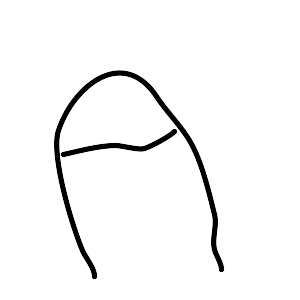

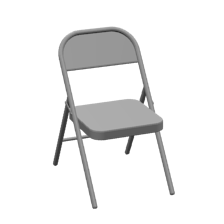

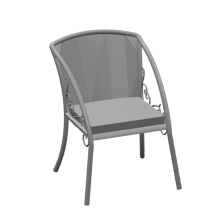

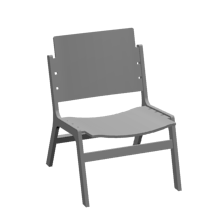

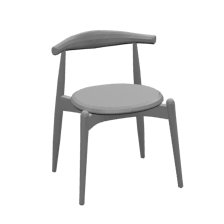

In [313]:
import urllib, cStringIO
from IPython.display import display

this_trial = 5 ## this one of folding chair seems pretty obvious

this_sketch_url = stimdict[this_trial]['sketch_url']
f = cStringIO.StringIO(urllib.urlopen(this_sketch_url).read())
x = Image.open(f)

this_url = stimdict[this_trial]['target']['url']
f = cStringIO.StringIO(urllib.urlopen(this_url).read())
t = Image.open(f)

this_url = stimdict[this_trial]['distractor1']['url']
f = cStringIO.StringIO(urllib.urlopen(this_url).read())
d1 = Image.open(f)

this_url = stimdict[this_trial]['distractor2']['url']
f = cStringIO.StringIO(urllib.urlopen(this_url).read())
d2 = Image.open(f)

this_url = stimdict[this_trial]['distractor3']['url']
f = cStringIO.StringIO(urllib.urlopen(this_url).read())
d3 = Image.open(f)

display(x,t,d1,d2,d3)

In [314]:
catch_trial_imgs = stimdict[this_trial]

## save out catch_trial_imgs in stimuli folder and in the experiments foler
import json
with open(os.path.join(proj_dir,'stimuli','catch_trial_imgs.js'), 'w') as fout:
     json.dump(catch_trial_imgs, fout)
        
with open(os.path.join(exp_dir,'recog','catch_trial_imgs.js'), 'w') as fout:
     json.dump(catch_trial_imgs, fout)        